# Statistical inference

We will use the data and model approach we have finalized to infer built-up land cover on the enter time period of 2016 through 2019.

## Fit model

This just executes the code to integrate our data and train our model (with the "optimal" final hyperparameters) as we developed previously:

In [11]:
import geemap, ee
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import anderson_ksamp, ttest_ind

try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

# define some functions and variables
def se2mask(image):
    quality_band = image.select('QA60')
    cloudmask = 1 << 10
    cirrusmask = 1 << 11
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    return image.updateMask(mask).divide(10000)


se2bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A']
trainingbands = se2bands + ['avg_rad']
label = 'smod_code'
scaleFactor=1000

# create training data
roi = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(ee.Filter.eq('ADM2_NAME','Bagmati')).geometry()

se2 = ee.ImageCollection('COPERNICUS/S2').filterDate(
    "2015-07-01","2015-12-31").filterBounds(roi).filter(
    ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",20)).map(se2mask).median().select(se2bands).clip(roi)

viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(
    "2015-07-01","2019-12-31").filterBounds(roi).median().select('avg_rad').clip(roi)

fused = se2.addBands(viirs)

# create and overlay labels to training data
ghsl = ee.ImageCollection('JRC/GHSL/P2016/SMOD_POP_GLOBE_V1').filter(ee.Filter.date(
    '2015-01-01', '2015-12-31')).select(label).median().gte(2)

points = ghsl.sample(**{"region":roi, "scale":scaleFactor,"seed":0,'geometries':True})

data = fused.select(trainingbands).sampleRegions(collection=points,
                                                        properties=[label],
                                                        scale=scaleFactor)

# fit classifier on entire dataset
new_params = {"numberOfTrees":500, 
              "variablesPerSplit":None,  
              "minLeafPopulation":1, 
              "bagFraction":0.5, 
              "maxNodes":None, 
               "seed":0}
clf = ee.Classifier.smileRandomForest(**new_params).train(data, label, trainingbands)

## Prep new data

In order to predict the data we need to prep (including fuse) the unseen data just as we did with the training data, but we'll do this for each year.

For the scope of this excercise, we're doing this at an annual level, but you could do this to produce a monthly time series. Try it yourself!

In [6]:
def img_prep(se2collection,
            viirscollection,
            year,
            se2bands,
            roi,
            se2maskfunc,
            scaleFactor):
    se2 = se2collection.filterDate(f"{year}-01-01",f"{year}-12-31").filterBounds(roi).filter(
        ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",20)).map(se2maskfunc).median().select(se2bands).clip(roi)
    
    viirs = viirscollection.filterDate(
        f"{year}-01-01",f"{year}-12-31").filterBounds(roi).median().select('avg_rad').clip(roi)
    return se2.addBands(viirs)

## Run inference on all years (2016-2019)

In [7]:
allyears = []

for year in ['2016','2017','2018','2019']:
    img = img_prep(se2collection=ee.ImageCollection('COPERNICUS/S2'),
                    viirscollection=ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG"),
                    year=year,
                    se2bands=se2bands,
                    roi=roi,
                    se2maskfunc=se2mask,
                    scaleFactor=scaleFactor)
    allyears.append(img.classify(clf))

## Histograms

As with {doc}`mod4_2_histograms` we can plot histograms.

Since our values are binary our distributions are not all that informative...there are better ways to visualize, but these do give a good idea of the shifts in built-up land.

In [8]:
allyears_arrs = [img.sample(region=roi, scale=scaleFactor, numPixels=1000) for img in allyears]
allyears_arrs = [np.asarray(arr.reduceColumns(ee.Reducer.toList(1), 
                                              ['classification']).values().get(0).getInfo()) for arr in allyears_arrs]

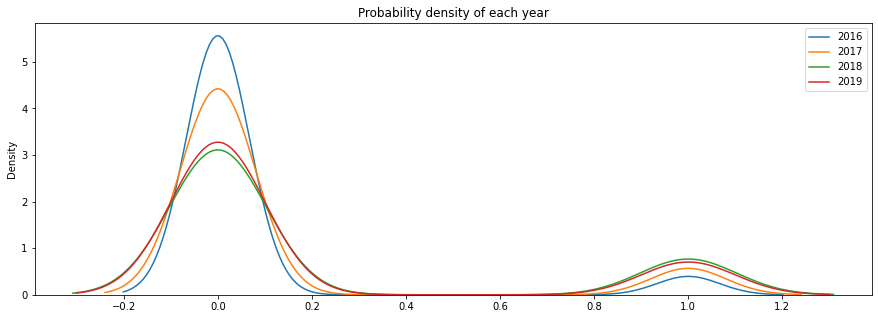

In [9]:
fig, ax = plt.subplots(1, figsize=(15,5))
for arr,yr in zip(allyears_arrs, ['2016','2017','2018','2019']):
    sns.kdeplot(arr.flatten(), label=yr)
plt.legend()
plt.title('Probability density of each year');

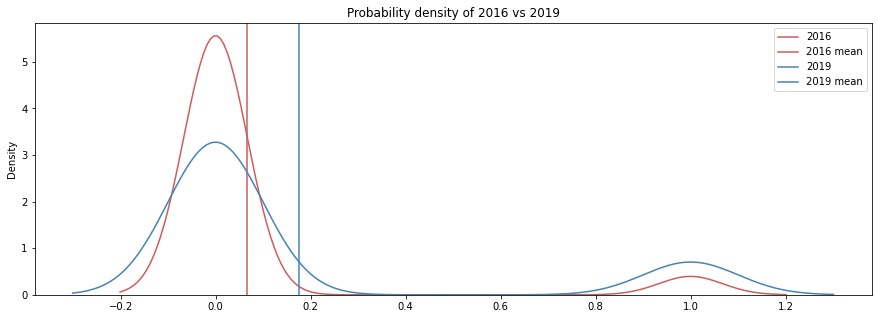

In [10]:
fig, ax = plt.subplots(1, figsize=(15,5))
for arr,yr,c in zip([allyears_arrs[0],allyears_arrs[-1]], ['2016','2019'], ['indianred','steelblue']):
    sns.kdeplot(arr.flatten(), c=c, label=yr)
    ax.axvline(arr.mean(), c=c, label=f"{yr} mean")
plt.legend()
plt.title('Probability density of 2016 vs 2019');

We can clearly see a positive shift built-up area...but is is statistically signifant? 

Lets conduct a t-test of means to find out.

## Hypothesis test

In [14]:
ttest_ind(allyears_arrs[-1], allyears_arrs[0])

Ttest_indResult(statistic=array([6.56129444]), pvalue=array([7.31722682e-11]))

Indeed, using an a 2-tailed t-test of means indicates that we can reject the null hypothesis with a p value far below our established 0.01 alpha threshold.

Our analysis indicates that Bagmati has seen change, specifically positive growth, in built-up land cover from 2016 to 2019.

Let's map the change to see spatial distribution.

In [15]:
# initialize our map
map1 = geemap.Map()
map1.centerObject(roi, 9)
map1.addLayer(allyears[-1].subtract(allyears[0]), {"min":-1.0, "max":1.0}, 'diff')
map1.addLayerControl()
map1

Map(center=[27.87388743003947, 85.41973735675019], controls=(WidgetControl(options=['position'], widget=HBox(c…

## Concluding thoughts

While we do have a truncated region (along the top) from what is visible we clearly see the positive growth (white) along the road network -- something we saw earlier when looking at the nighttime lights scene.

The statistical test of variance demonstrates that if our classifier and our assumptions are valid, it would indicate that from 2016 to 2019 we saw increase built-up land and therefore economic growth in the Province of Bagmati. Furthermore, we can see patterns in growth along major road infrastructure...perhaps a connection for you to discover: is there a causal relationship between road investment and economic growth and can remote sensing help to answer this?